<a href="https://colab.research.google.com/github/Kedrynez/Yandex_Practicum/blob/main/advanced_SQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import seaborn as sns
from sqlalchemy import create_engine 

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

### Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.  
Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

In [4]:
query = '''
SELECT DATE_TRUNC('month', creation_date)::date AS month_date,
       SUM(views_count) AS total_views
FROM stackoverflow.posts
WHERE EXTRACT(YEAR FROM creation_date) = 2008
GROUP BY 1
ORDER BY 2 DESC
'''

pd.read_sql_query(query, con=engine)

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Данные за разные месяцы отличаются. Наименьшее количество просмотров в июле связано с тем, что публичный доступ к сайту был открыт в конце июля 2008 года. Рост числа просмотров к сентябрю связан с ростом популярности сайта. Падение количества просмотров с сентября -  меньше уникальных ситуаций возникает у программистов, с ними уже кто-то сталкивался и они решены ранее.

### Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.  
Какие аномалии наблюдаются в данных? О чём они говорят?

In [5]:
query = '''
SELECT u.display_name,
        COUNT(DISTINCT u.id)
FROM stackoverflow.posts p
JOIN stackoverflow.post_types pt ON p.post_type_id = pt.id
JOIN stackoverflow.users u ON p.user_id = u.id
WHERE pt.type = 'Answer' AND p.creation_date < u.creation_date + INTERVAL '1 months'
GROUP BY u.display_name
HAVING COUNT(p.id) > 100
ORDER BY 1
'''

df2 = pd.read_sql_query(query, con=engine)
df2.set_index('display_name').head(10)

,count
display_name,
1800 INFORMATION,1
Adam Bellaire,1
Adam Davis,1
Adam Liss,1
Alan,8
Amy B,1
Ben Hoffstein,1
Brian,15
Cade Roux,1


In [6]:
df_anom = df2.loc[df2['count'] > 1]  \
.sort_values(by='count', ascending=False)  \
.reset_index(drop=True)
display(df_anom)
df_anom['count'].sum()

,display_name,count
0,Chris,29
1,Matt,29
2,Dan,21
3,Tom,19
4,Josh,16
5,Mark,16
6,Nick,16
7,Brian,15
8,Rob,15
9,Greg,12


254

В качестве аномалий наблюдается количество user_id, превышающее значение 1.  
Это говорит о том, что есть пользователи с одинаковыми именами (никнеймами).  
В данном случае - на 19 имен пользователей приходится 254 уникальных user_id.

### Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.  
Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

In [7]:
query = '''
SELECT DATE_TRUNC('month', p.creation_date)::date,
       COUNT(p.id)
FROM stackoverflow.posts p
WHERE p.user_id IN
(SELECT  DISTINCT u.id
FROM stackoverflow.users u
JOIN stackoverflow.posts p ON p.user_id=u.id
WHERE DATE_TRUNC('month', u.creation_date)::date = '2008-09-01'
AND DATE_TRUNC('month', p.creation_date)::date = '2008-12-01')
GROUP BY DATE_TRUNC('month', p.creation_date)::date
ORDER BY 1 DESC
'''
pd.read_sql_query(query, con=engine).set_index('date_trunc')

,count
date_trunc,
2008-12-01,17641
2008-11-01,18294
2008-10-01,27171
2008-09-01,24870
2008-08-01,32


In [8]:
query = '''
WITH users AS
(SELECT  DISTINCT u.id
FROM stackoverflow.users u
JOIN stackoverflow.posts p ON p.user_id=u.id
WHERE DATE_TRUNC('month', u.creation_date)::date = '2008-09-01'
AND DATE_TRUNC('month', p.creation_date)::date = '2008-12-01')

SELECT DATE_TRUNC('month', p.creation_date)::date,
       COUNT(p.id)
FROM users u
JOIN stackoverflow.posts p ON p.user_id=u.id
GROUP BY DATE_TRUNC('month', p.creation_date)::date
ORDER BY 1 DESC
'''

pd.read_sql_query(query, con=engine).set_index('date_trunc')

,count
date_trunc,
2008-12-01,17641
2008-11-01,18294
2008-10-01,27171
2008-09-01,24870
2008-08-01,32



Аномальные значения в августе. Не мог появится пост в августе от пользователя, который зарегистрировался только в сентябре. Это связано с технической ошибкой.  

### Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

In [9]:
query = '''
SELECT p.user_id,
       p.creation_date,
       p.views_count,
       SUM(views_count) OVER(PARTITION BY p.user_id ORDER BY creation_date) AS cumulative_count
FROM stackoverflow.posts p
ORDER BY p.user_id, p.creation_date
'''

pd.read_sql_query(query, con=engine).set_index('user_id')

,creation_date,views_count,cumulative_count
user_id,,,
1,2008-07-31 23:41:00,480476,480476
1,2008-07-31 23:55:38,136033,616509
1,2008-07-31 23:56:41,0,616509
1,2008-08-04 02:45:08,0,616509
1,2008-08-04 04:31:03,0,616509
...,...,...,...
5696608,2008-12-23 16:00:37,0,2804
5696608,2008-12-23 17:35:09,0,2804
5696608,2008-12-24 01:02:48,0,2804


### Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

In [10]:
query = '''
WITH df AS
(SELECT p.user_id,
       DATE_TRUNC('day', p.creation_date)::date,
       COUNT(p.id)
FROM stackoverflow.posts p
WHERE user_id IN
  (SELECT user_id
  FROM stackoverflow.posts
  WHERE DATE_TRUNC('month', creation_date)::date = '2008-08-01'
  GROUP BY user_id
  HAVING COUNT(id) > 120)
GROUP BY p.user_id, DATE_TRUNC('day', p.creation_date)::date)
SELECT d.user_id,
       AVG(d.count)
FROM df d
WHERE DATE_TRUNC('month', d.date_trunc)::date = '2008-08-01'
GROUP BY 1
ORDER BY 2
'''

pd.read_sql_query(query, con=engine).set_index('user_id')

,avg
user_id,
116,4.777778
234,5.208333
91,5.681818
905,7.000000
383,7.277778


### Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат.  
Проанализируйте итоговую таблицу — какие выводы можно сделать?

In [11]:
query = '''
WITH df AS
(SELECT user_id,
       COUNT(DISTINCT DATE_TRUNC('day', creation_date)::date)
FROM stackoverflow.posts
WHERE DATE_TRUNC('day', creation_date)::date 
BETWEEN '2008-12-01' AND '2008-12-07'
GROUP BY 1)
SELECT CEILING(AVG(count))::int AS result
FROM df
'''


pd.read_sql_query(query, con=engine).set_index('result')

""
result
2


За период с 1 по 7 декабря пользователи взаимодействовали с платформой в среднем 2 дня.

### Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

In [12]:
query = '''
WITH df AS 
(SELECT user_id,
       creation_date,
       LAG(creation_date, 2) OVER(PARTITION BY user_id ORDER BY creation_date)::date
FROM stackoverflow.posts
ORDER BY 1,2)
SELECT user_id,
       creation_date,
       CASE
           WHEN EXTRACT(MONTH FROM lag) = 7.0 THEN 'July'
           WHEN EXTRACT(MONTH FROM lag) = 8.0 THEN 'August'
           WHEN EXTRACT(MONTH FROM lag) = 9.0 THEN 'September'
           WHEN EXTRACT(MONTH FROM lag) = 10.0 THEN 'October'
           WHEN EXTRACT(MONTH FROM lag) = 11.0 THEN 'November'
           WHEN EXTRACT(MONTH FROM lag) = 12.0 THEN 'December'
       END    
FROM df
'''


pd.read_sql_query(query, con=engine).set_index('user_id')

,creation_date,case
user_id,,
1,2008-07-31 23:41:00,None
1,2008-07-31 23:55:38,None
1,2008-07-31 23:56:41,July
1,2008-08-04 02:45:08,July
1,2008-08-04 04:31:03,July
...,...,...
5696608,2008-12-23 16:00:37,December
5696608,2008-12-23 17:35:09,December
5696608,2008-12-24 01:02:48,December


### Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце.  
Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

In [13]:
query = '''
WITH profile AS
(WITH df AS
(SELECT DISTINCT user_id,
       FIRST_VALUE(DATE_TRUNC('month', creation_date)) OVER 
       (PARTITION BY user_id ORDER BY DATE_TRUNC('month', creation_date)) cohort_dt
FROM stackoverflow.posts)
SELECT *,
      COUNT(user_id) OVER(PARTITION BY cohort_dt) AS cohort_users_cnt
FROM df),

sessions AS
(SELECT user_id,
       DATE_TRUNC('month', creation_date) AS session_date
FROM stackoverflow.posts
GROUP BY 1, 2)

SELECT p.cohort_dt,
       s.session_date,
       COUNT(p.user_id) AS users_cnt,
       p.cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profile p JOIN sessions s ON p.user_id=s.user_id
GROUP BY 1, 2, 4
'''

df8 = pd.read_sql_query(query, con=engine)
df8

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


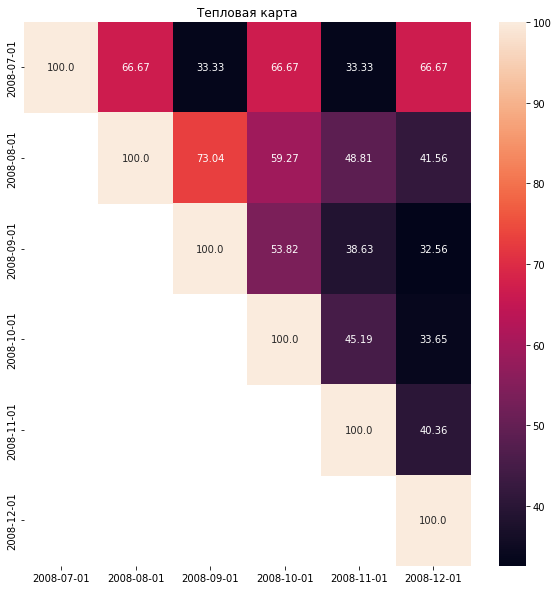

In [14]:
retention = df8.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]
plt.figure(figsize=(10, 10)) 
sns.heatmap(retention, 
            annot=True, 
            fmt='') 
plt.title('Тепловая карта') 
plt.show() 

Аномалии - для первой когорты (от июля) удержание "скачет". В то время как теоретически удержание убывает по экспотенциальному закону.   
Причина - возможно техническая ошибка.
Закономерности - начиная со второй когорты удержание хуже (уменьшается) от когорты к когорте.  
Причина - возможно, пользователи реже сталкиваются с чем-то уникальным.

### Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.   
Постройте круговую диаграмму с количеством постов по месяцам.

In [15]:
query = '''
WITH df AS
(SELECT EXTRACT(MONTH FROM creation_date)::int AS creation_month,
       COUNT(id) AS posts_count
FROM stackoverflow.posts
WHERE EXTRACT(MONTH FROM creation_date)::int BETWEEN 9 AND 12
GROUP BY creation_month)
SELECT *,
       ROUND((posts_count::numeric/LAG(posts_count) OVER()-1)*100,2)
FROM df
'''

df9 = pd.read_sql_query(query, con=engine)
df9

,creation_month,posts_count,round
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


In [16]:
mylabels = ["Сентябрь", "Октябрь", "Ноябрь", "Декабрь"]
fig = go.Figure(data=[go.Pie(labels=mylabels, values=df9.posts_count,  \
                             pull=[0.1, 0, 0, 0])])
fig.update_layout(legend=dict(yanchor="top", y=0.95, xanchor="center"),
                  title="Cоотношение количества постов по месяцам", title_x = 0.7,
                  title_font_size=18,
                  margin=dict(l=0, r=0, t=25, b=0))
fig.show() 

### Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

In [17]:
query = '''
WITH us AS
(SELECT user_id,
       COUNT(id)
FROM stackoverflow.posts
GROUP BY 1
ORDER BY 2 DESC
LIMIT 1)
SELECT EXTRACT(WEEK FROM p.creation_date)::int week_creation,
       MAX(p.creation_date) creation_date
FROM us u 
JOIN stackoverflow.posts p ON u.user_id=p.user_id
WHERE DATE_TRUNC('month', p.creation_date)::date = '2008-10-01'
GROUP BY 1
'''

pd.read_sql_query(query, con=engine).set_index('week_creation')

,creation_date
week_creation,
40,2008-10-05 09:00:58
41,2008-10-12 21:22:23
42,2008-10-19 06:49:30
43,2008-10-26 21:44:36
44,2008-10-31 22:16:01


### Вывод  

Для выполнения поставленных задач было выполнено подключение к базе с использованием SQLAlchemy.  
С помощью SQL-запросов в Jupyter Notebook были получены данные из таблиц схемы stackoverflow.
Все задачи решены.
На все поставленные вопросы даны ответы.

Текстовые ответы на вопросы, где это требовалось, приведены ниже.   
* Задание 1 - Данные за разные месяцы отличаются. Наименьшее количество просмотров в июле связано с тем, что публичный доступ к сайту был открыт в конце июля 2008 года. Рост числа просмотров к сентябрю связан с ростом популярности сайта. Падение количества просмотров с сентября -  меньше уникальных ситуаций возникает у программистов, с ними уже кто-то сталкивался и они решены ранее. 
* Задание 2 - В качестве аномалий наблюдается количество user_id, превышающее значение 1.  
Это говорит о том, что есть пользователи с одинаковыми именами (никнеймами).  
В данном случае - на 19 имен пользователей приходится 254 уникальных user_id.
* Задание 3 - Аномальные значения в августе. Не мог появится пост в августе от пользователя, который зарегистрировался только в сентябре. Это связано с технической ошибкой.
* Задание 6 - За период с 1 по 7 декабря пользователи взаимодействовали с платформой в среднем 2 дня.  
* Задание 8 - Аномалии - для первой когорты (от июля) удержание "скачет". В то время как теоретически удержание убывает по экспотенциальному закону.
Причина - возможно техническая ошибка.  
Закономерности - начиная со второй когорты удержание хуже (уменьшается) от когорты к когорте.
Причина - возможно, пользователи реже сталкиваются с чем-то уникальным.  





